### Dataset review

- **Dataset presentation:** The dataset consists of online poker games. There are multiple columns represent the features of the game and the column named result is the label of the dataset which indicates the performance of the player.

- **File conversion:** We did not need to convert the data format, we used the read_csv function from pandas.

- **Entry count:** The dataset consists of 102615 entries. After carefully examining the dataset, we found that there was just one player with id=fa538846 who had sufficient data to be considered. All the others had missing data essential for the analysis. Therefore, we decided to remove all the players except for the one. This resulted in a dataset with 41303 entries.

- **Attribute count:** The dataset consists of 35 attributes with many different types. There are categorical, nominal, numerical and binary data types. More precisely all the columns related to card values such as cards, board_flop, board_turn etc are ordinal because they have a natural order. Other columns that describe some actions of the game such as call, raise etc are nominal and we used one hot encoding to replace them with binary features. There is one binary column called all_in and the rest of them are numerical. The label column with name result is categorical. During the analysis we understood that there are some columns that are not useful and we decided to remove them. The dropped columns are: buyin, tourn_id, table, hand_id, date, time, table_size, seat, name and combination. Additionally, we decided to remove the column with name balance because it provides information on the final result (which is what we want to predict) and we do not want to use it as a feature.

- **Indexes and headers:** There are row indexes and column headers.

- **Class labels:** Class labels (found in column 34) are categorical and represent if the player won, lost, gave up or took chips. 

- **Missing values:** There is just one column with missing values, the column named combination in which the 82% are missing values. Considering the content of the column which is the cards combination of each player we thought that the replication of missing rows does not make any sense. Apart from this, the big amount of missing values was another indication that this column should be removed from the training process.

- **Class count:** As we can see from the table below, the dataset is not balanced.

Class      | Number of instances | Percentages |
----------- | ----------- | ----------- |
won      | 4228       | 10.2% |
lost         | 3570       | 8.6% |
gave up   | 21359        | 51.7% |
took chips         | 12146       | 29.5% |
    


      



In [ ]:
import os
import numpy as np
import pandas as pd
import sklearn as sk
import matplotlib as mpl
from sklearn.metrics import classification_report
from sklearn.feature_selection import VarianceThreshold
from sklearn.preprocessing import OrdinalEncoder
from tqdm.notebook import tqdm 

from google.colab import drive
drive.mount('/content/drive')

import warnings
warnings.filterwarnings('ignore')
df = pd.read_csv("/content/drive/My Drive/one_dollar_spin_and_go.csv")

# keep rows with name = fa538846
df = df[df['name'] == 'fa538846']


df.reset_index(drop=True, inplace=True)
# drop columns
df = df.drop(['buyin', 'tourn_id', 'table', 'hand_id', 'date', 'time','table_size' ,'seat', 'name', 'combination','balance'], axis=1)


# From column 'cards' we create 5 new columns for each card x={1,2} ('card_value_x', 'card_suit__c', 'card_suit__d', 'card_suit__h', 'card_suit__s')
# We will use OrdinalEncoder to transform the values of the columns 'card_value_x' into numerical values
# We will use OneHotEncoder to transform the values of the columns 'card_suit_x' into several columns with binary values

df['card_value_1'] = df['cards'].str.split(' ').str[0].str[0]
df['card_suit_1'] = df['cards'].str.split(' ').str[0].str[1]
df['card_value_2'] = df['cards'].str.split(' ').str[1].str[0]
df['card_suit_2'] = df['cards'].str.split(' ').str[1].str[1]


# define ordinal encoder with playing card values as categories
ordinal_encoder_cards = OrdinalEncoder(categories=[['0','2', '3', '4', '5', '6', '7', '8', '9', 'T', 'J', 'Q', 'K', 'A']])

# fit and transform the card_value_1 and card_value_2 columns
df['card_value_1'] = ordinal_encoder_cards.fit_transform(df[['card_value_1']])
df['card_value_2'] = ordinal_encoder_cards.fit_transform(df[['card_value_2']])


# define one hot encoder for card_suit_1 and card_suit_2
one_hot_encoder = sk.preprocessing.OneHotEncoder(sparse=False)


# use one hot encoder to transform card_suit_1 and card_suit_2 and save the result in new columns
oneHotEncodedDf = pd.DataFrame(one_hot_encoder.fit_transform(df[['card_suit_1', 'card_suit_2']]))
oneHotEncodedDf.columns = one_hot_encoder.get_feature_names_out()

df = pd.concat([df, oneHotEncodedDf], axis=1 )


# do the same as above for the columns board_flop, board_turn and board_river if values is not 0
# replace 0 with "00 00 00"
df['board_flop'] = df['board_flop'].replace('0', '00 00 00')

df['board_flop_1'] = df['board_flop'].str.split(' ').str[0].str[0]
df['board_flop_suit_1'] = df['board_flop'].str.split(' ').str[0].str[1]
df['board_flop_2'] = df['board_flop'].str.split(' ').str[1].str[0]
df['board_flop_suit_2'] = df['board_flop'].str.split(' ').str[1].str[1]
df['board_flop_3'] = df['board_flop'].str.split(' ').str[2].str[0]
df['board_flop_suit_3'] = df['board_flop'].str.split(' ').str[2].str[1]

df['board_flop_1'] = ordinal_encoder_cards.fit_transform(df[['board_flop_1']])
df['board_flop_2'] = ordinal_encoder_cards.fit_transform(df[['board_flop_2']])
df['board_flop_3'] = ordinal_encoder_cards.fit_transform(df[['board_flop_3']])
oneHotEncodedDf = pd.DataFrame(one_hot_encoder.fit_transform(df[['board_flop_suit_1', 'board_flop_suit_2', 'board_flop_suit_3']]))
oneHotEncodedDf.columns = one_hot_encoder.get_feature_names_out()
df = pd.concat([df, oneHotEncodedDf], axis=1)

# replace 0 with "00"
df['board_turn'] = df['board_turn'].replace('0', '00')

df['board_turn_value'] = df['board_turn'].str.split(' ').str[0].str[0]
df['board_turn_suit'] = df['board_turn'].str.split(' ').str[0].str[1]
df['board_turn_value'] = ordinal_encoder_cards.fit_transform(df[['board_turn_value']])
oneHotEncodedDf = pd.DataFrame(one_hot_encoder.fit_transform(df[['board_turn_suit']]))
oneHotEncodedDf.columns = one_hot_encoder.get_feature_names_out()
df = pd.concat([df, oneHotEncodedDf], axis=1)

# replace 0 with "00"
df['board_river'] = df['board_river'].replace('0', '00')

df['board_river_value'] = df['board_river'].str.split(' ').str[0].str[0]
df['board_river_suit'] = df['board_river'].str.split(' ').str[0].str[1]
df['board_river_value'] = ordinal_encoder_cards.fit_transform(df[['board_river_value']])
oneHotEncodedDf = pd.DataFrame(one_hot_encoder.fit_transform(df[['board_river_suit']]))
oneHotEncodedDf.columns = one_hot_encoder.get_feature_names_out()
df = pd.concat([df, oneHotEncodedDf], axis=1)

# drop the columns
df = df.drop(['cards', 'card_suit_1', 'card_suit_2', 'board_flop', 'board_turn', 'board_river', 'board_flop_suit_1', 'board_flop_suit_2', 'board_flop_suit_3', 'board_turn_suit', 'board_river_suit'], axis=1)


# use one hot on the columns 'position', 'action_pre', 'action_flop', 'action_turn', 'action_river'
oneHotEncodedDf = pd.DataFrame(one_hot_encoder.fit_transform(df[['position', 'action_pre', 'action_flop', 'action_turn', 'action_river']]))
oneHotEncodedDf.columns = one_hot_encoder.get_feature_names_out()
df = pd.concat([df, oneHotEncodedDf], axis=1)
df = df.drop(['position', 'action_pre', 'action_flop', 'action_turn', 'action_river'], axis=1)

# use label encoder on the column 'result'
label_encoder = sk.preprocessing.LabelEncoder()
df['result'] = label_encoder.fit_transform(df['result'])

y= df['result']


### Dataset split

- **Splitting method:** We used the train_test_split function from sklearn.model_selection to split the dataset into training and testing sets. We used a 70/30 split, meaning that 70% of the dataset was used for training and 30% for testing. We selected this ratio because we wanted to have a good amount of data for training and at the same time we wanted to have enough data for testing.

- **Cross validation:**  We used 10 fold cross validation because we undersampled the classes to make the dataset balanced. This way we weren't too concerned about a class not being present in our training set and we used 5 folds to save time. 

In [2]:
from sklearn.model_selection import train_test_split

# Split the data into training and test sets
X = df.drop(['result'], axis=1)
y= df['result']

#split the df into train and test sets with 30% of the data in the test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)


### Dataset metrics

- **Metric selection:** We used the accuracy score and the f1_micro as the metrics for evaluating the performance of the models. As about the accuracy score it is considered the most common metric for classification problems. It is also easy to understand and interpret. The accuracy score is the ratio of the number of correct predictions to the total number of predictions. It is a good metric for our problem because we want to know how many times the model predicted the correct class. The f1_micro is the harmonic mean of the precision and recall. It is a good metric for our problem because we want to know how many times the model predicted the correct class and how many times it predicted the wrong class. The f1_micro is a good metric for our problem because we want to know how many times the model predicted the correct class and how many times it predicted the wrong class.

In [3]:
from sklearn.metrics import accuracy_score
from sklearn.metrics import f1_score

In [4]:
from sklearn.neural_network import MLPClassifier
from sklearn.svm import SVC
from sklearn.dummy import DummyClassifier

# create a list of models
models = []
models.append(DummyClassifier())
models.append(MLPClassifier())
models.append(SVC())

### Out of the box performance

- **OOB classifiers:** As we can see from the below results the MLPClassifier has better performance metrics in comparison with the SVC classifier but both of them have very good performance metrics even without tuning the hyperparameters. This shows that the default hyperparameters may be good enough for this dataset's analysis.

|                 |   Accuracy OOB |   F1 Score OOB |
|:----------------|---------------:|---------------:|
| DummyClassifier |       0.514002 |       0.349006 |
| MLPClassifier   |       0.931321 |       0.931051 |
| SVC             |       0.838996 |       0.812634 |

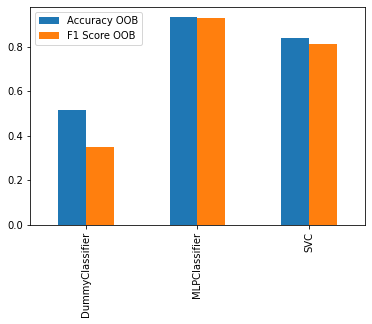

In [5]:
# fit the classifiers and print the accuracy and f1 score for each classifier and save them in a dataframe
out_of_the_box_df = pd.DataFrame(columns=['Accuracy OOB', 'F1 Score OOB'])
for clf in models:
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    out_of_the_box_df.loc[clf.__class__.__name__] = [accuracy_score(y_test, y_pred), f1_score(y_test, y_pred, average='weighted')]


from IPython.display import Markdown as md


# display the results of the classifiers in a comparison bar plot
comparisonBarPlot = out_of_the_box_df.plot.bar()

# display the results of the classifiers in a markdown table
markDownTableResults = out_of_the_box_df.to_markdown()
md(markDownTableResults)

### **MLP Classifier training**

#### **Data preprocessing:** We tested a combination of data preprocessing techniques, including:

- **Standardization:** We used the MinMaxScaler for standarisizing the data. We did not use the StandardScaler because it is sensitive to outliers.

- **Feature selection:** We used the VarianceThreshold to remove features with low variance. We tested thresholds from 0.0 to 0.1 and we found that 0.0 is the best option.

- **Sampling:** We used the RandomUnderSampler undersample the majority classes. We avoided using the oversampling techniques because we had a large volume of data and we wanted to avoid overfitting and large training times.

- **Feature extraction:** We used the PCA to reduce the dimensionality of the data. We tested the number of components from 1% to 99% and we found that 99% is the best option. In the end we found out that PCA does not make a differenence so we removed it.

<br/>


#### **MLP Classifier:** We used the MLPClassifier from sklearn.neural_network to train our model. We tested different combinations of parameters and we found that the best combination is:


<br/>

#### **Hyperparameter tuning methodology:** We used the both HalvingRandomSearchCV and HalvingGridSearchCV to find the best combination of parameters. We began with the HalvingRandomSearchCV and we tested a large spectrum of choices for every hyperparameter. We then used the HalvingGridSearchCV to narrow down the choices for every hyperparameter. In the end, we used the HalvingGridSearchCV to find the best combination of parameters, based on the results we found on our previous tests. In our first two tests, we used the exact same parameters without narrowing them down but we changed the scoring function to from accuracy to f1_micro. We found that the best results occured when we used the f1_micro scoring function, so we used it for the rest of the tests.



### **Test results and analysis:**

#### **Test 1 HalvingRandomSearchCV with scoring = 'accuracy'**

##### **Test parameters:**

Hyperparameter | Values |
----------- | ----------- |
selector__threshold | [0.0, 0.05, 0.1] |
pca__n_components | [0.1, 0.35, 0.75, 0.9] |
clf__solver | ['sgd', 'adam'] |
clf__activation | ['tanh', 'relu'] |
clf__alpha | [0.01, 0.1, 0.5, 1, 2] |
clf__hidden_layer_sizes | [(100, 100), (100, 100, 100), (100, 100, 100, 100)] |

##### **Best parameters:**

Hyperparameter | Values |
----------- | ----------- |
selector__threshold | 0.0 |
pca__n_components | 0.9 |
clf__solver | adam |
clf__activation | tanh |
clf__alpha | 0.1 |
clf__hidden_layer_sizes | (100, 100)


##### **Test score:**
Scores |   Accuracy | 	F1 Score |
----------- | ----------- | ----------- |
Pipeline |	0.907917 |	0.909672 |

##### **Comment:** These scores will be used to compare the accuracy and f1 micro scoring functions.

<br/>

#### **Test 2 HalvingRandomSearchCV with scoring = 'f1_micro'**

##### **Test parameters:**

Hyperparameter | Values |
----------- | ----------- |
selector__threshold | [0.0, 0.05, 0.1] |
pca__n_components | [0.1, 0.35, 0.75, 0.9] |
clf__solver | ['sgd', 'adam'] |
clf__activation | ['tanh', 'relu'] |
clf__alpha | [0.01, 0.1, 0.5, 1, 2] |
clf__hidden_layer_sizes | [(100, 100), (100, 100, 100), (100, 100, 100, 100)] |

##### **Best parameters:**

Hyperparameter | Values |
----------- | ----------- |
selector__threshold | 0.0 |
pca__n_components | 0.9 |
clf__solver | adam |
clf__activation | tanh |
clf__alpha | 0.1 |
clf__hidden_layer_sizes | (100, 100)


##### **Test score:**
Scores |   Accuracy | 	F1 Score |
----------- | ----------- | ----------- |
Pipeline |	0.919538 |	0.920614 |

##### **Comment:** Comparing the scores of test 1 and 2, we came to the conclusion that the f1_micro scoring function produces better results, so we will use it in our next tests. For the next test we will narrow down the values for every hyperparameter to values closer to the optimal value from this test.

<br/>

#### **Test 3 HalvingRandomSearchCV with scoring = 'f1_micro'**


##### **Test parameters:**

Hyperparameter | Values |
----------- | ----------- |
selector__threshold | [0.0, 0.02, 0.5] |
pca__n_components | [0.85, 0.9, 0.99] |
clf__solver | ['sgd', 'adam'] |
clf__activation | ['tanh', 'relu'] |
clf__alpha | [0.05, 0.1, 0.15] |
clf__hidden_layer_sizes | [(100, 100), (100, 100, 100), (100, 100, 100, 100)] |

##### **Best parameters:**

Hyperparameter | Values |
----------- | ----------- |
selector__threshold | 0.0 |
pca__n_components | 0.99 |
clf__solver | adam |
clf__activation | tanh |
clf__alpha | 0.05 |
clf__hidden_layer_sizes | (100, 100)


##### **Test score:**
Scores |   Accuracy | 	F1 Score |
----------- | ----------- | ----------- |
Pipeline |	0.910096 |	0.911866 |

##### **Comment:** As we can see, the hyperparameters clf__solver and clf__activation always work better with the values 'adam' and 'tanh'. These will be our final values for those hyperparameters and we will stop testing for them. We also see the same pattern for clf__hidden_layer_sizes, we will continue testing but only choices closer to the (100, 100) choice.

<br/>

#### **Test 4 GridSearchCV with scoring = 'f1_micro'**


##### **Test parameters:**


Hyperparameter | Values |
----------- | ----------- |
selector__threshold | [0.0, 0.01] |
pca__n_components | [0.98, 0.99] |
clf__alpha | [0.02, 0.05, 0.07] |
clf__hidden_layer_sizes | [(100, 100), (100, 100, 100)] |

##### **Best parameters:**

Hyperparameter | Values |
----------- | ----------- |
selector__threshold | 0.0 |
pca__n_components | 0.99 |
clf__alpha | 0.07 |
clf__hidden_layer_sizes | (100, 100)


##### **Test score:**
Scores |   Accuracy | 	F1 Score |
----------- | ----------- | ----------- |
Pipeline |	0.912194 |	0.913875 |

##### **Comment:** Since the hyperparameter values were almost completely optimized, we used GridSearchCV for our last test, because training time was not a problem (few combinations needed to be tested). The final testing score was marginally better than the previous versions.

<br/>




In [ ]:
from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline
from sklearn.decomposition import PCA
from sklearn.feature_selection import VarianceThreshold
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV

from sklearn.experimental import enable_halving_search_cv
# from sklearn.model_selection import HalvingGridSearchCV
from sklearn.model_selection import HalvingRandomSearchCV


# Initialize the transformers without hyperparameters
selector = VarianceThreshold()
scaler = MinMaxScaler()
rus = RandomUnderSampler()
pca = PCA()

# Initialize the pipeline
pipe_mlp = Pipeline([('selector', selector), ('scaler', scaler), ('rus', rus), ('pca', pca), ('clf', MLPClassifier(solver="adam", activation="tanh"))], memory = 'tmp')

# Define the hyperparameters
param_grid_mlp = {
    'selector__threshold': [0.0, 0.01],
    'pca__n_components': [0.98, 0.99],
    'clf__alpha': [0.02, 0.05, 0.07],
    'clf__hidden_layer_sizes': [(100, 100), (100, 100, 100)]
} 

# Initialize the HalvingRandomSearchCV search
grid_mlp = GridSearchCV(pipe_mlp, param_grid_mlp, cv=10, n_jobs=-1, verbose=1, scoring='f1_micro')

# Fit the grid search
grid_mlp.fit(X_train, y_train)





0.9106945506946008
{'clf__alpha': 0.07, 'clf__hidden_layer_sizes': (100, 100), 'pca__n_components': 0.99, 'selector__threshold': 0.0}


|          |   Accuracy |   F1 Score |
|:---------|-----------:|-----------:|
| Pipeline |   0.912194 |   0.913875 |

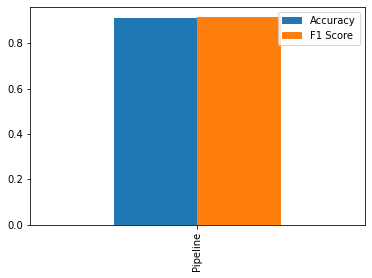

In [ ]:
# # # fit the classifiers and print the accuracy and f1 score for each classifier and save them in a dataframe
grid_mlp_df = pd.DataFrame(columns=['Accuracy', 'F1 Score'])
y_pred = grid_mlp.best_estimator_.predict(X_test)
grid_mlp_df.loc[grid_mlp.best_estimator_.__class__.__name__] = [accuracy_score(y_test, y_pred), f1_score(y_test, y_pred, average='weighted')]


print(grid_mlp.best_score_)
print(grid_mlp.best_params_)

from IPython.display import Markdown as md


# display the results of the classifiers in a comparison bar plot
comparisonBarPlot = grid_mlp_df.plot.bar()

# display the results of the classifiers in a markdown table
markDownTableResults = grid_mlp_df.to_markdown()
md(markDownTableResults)# # # # # # # # # # # 

In [ ]:
import optuna
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.decomposition import PCA
from imblearn.under_sampling import RandomUnderSampler 
from sklearn.feature_selection import VarianceThreshold
from imblearn.pipeline import Pipeline
from sklearn.model_selection import cross_val_score
import numpy as np
from sklearn.neural_network import MLPClassifier


# -- Define the objective function
def objective(trial):

    # -- Instantiate selector
    selector_threshold = trial.suggest_float('selector__threshold', 0.0, 0.1)

    selector = VarianceThreshold(threshold=selector_threshold)

    # -- Instantiate UnderSampler
    rus = RandomUnderSampler()

    # -- Instantiate scaler
    # (a) List scalers to chose from
    scalers = trial.suggest_categorical("scalers", ['minmax', 'standard'])

    # (b) Define your scalers
    if scalers == "minmax":
        scaler = MinMaxScaler()
    elif scalers == "standard":
        scaler = StandardScaler()

    # -- Instantiate dimensionality reduction
     # (a) List all dimensionality reduction options
    dim_red = trial.suggest_categorical("dim_red", ["PCA", None])

    # (b) Define the PCA algorithm and its hyperparameters
    if dim_red == "PCA":
        pca_n_components=trial.suggest_int("pca_n_components", 50, 171)
        dimen_red_algorithm=PCA(n_components=pca_n_components)
    # (c) No dimensionality reduction option
    else:
        dimen_red_algorithm='passthrough'

    # -- Instantiate estimator model
    alpha=trial.suggest_float('clf__alpha', 0.01, 2.0)
    solver=trial.suggest_categorical('clf__solver', ['adam', 'sgd'])
    activation=trial.suggest_categorical('clf__activation', ['relu', 'tanh'])

    estimator = MLPClassifier(alpha=alpha, solver=solver, activation=activation)

    ##########


    # -- Make a pipeline
    pipeline = Pipeline([('selector', selector), ('scaler', scaler), ('rus', rus), ('pca', dimen_red_algorithm), ('clf', estimator)], memory = 'tmp')

    # -- Evaluate the score by cross-validation
    score = cross_val_score(pipeline, X_train, y_train, scoring='accuracy', cv=5)
    acc = score.mean() # calculate the mean of scores
    return acc

study = optuna.create_study(direction="maximize") # maximise the score during tuning
study.optimize(objective, n_trials=20) # run the objective function 20 times

print(study.best_trial) # print the best performing pipeline

|          |   Accuracy |   F1 Score |
|:---------|-----------:|-----------:|
| Pipeline |    0.92656 |   0.927677 |

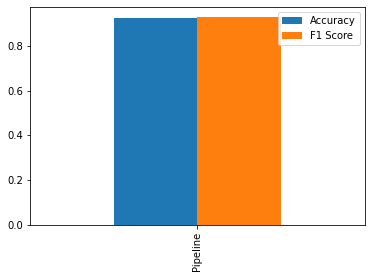

In [14]:
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline
from sklearn.feature_selection import VarianceThreshold
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.neural_network import MLPClassifier


# Initialize the transformers without hyperparameters
selector = VarianceThreshold(threshold=0.0024547727859665306)
scaler = StandardScaler()
rus = RandomUnderSampler()

# Initialize the pipeline
pipe_mlp_optuna = Pipeline([('selector', selector), ('scaler', scaler), ('rus', rus),  ('clf', MLPClassifier(alpha=1.8745876376736077,solver="sgd", activation="relu"))], memory = 'tmp')


# Fit the grid search
pipe_mlp_optuna.fit(X_train, y_train)


# # # fit the classifiers and print the accuracy and f1 score for each classifier and save them in a dataframe
pipe_mlp_optuna_df = pd.DataFrame(columns=['Accuracy', 'F1 Score'])
y_pred = pipe_mlp_optuna.predict(X_test)
pipe_mlp_optuna_df.loc[pipe_mlp_optuna.__class__.__name__] = [accuracy_score(y_test, y_pred), f1_score(y_test, y_pred, average='weighted')]



from IPython.display import Markdown as md


# display the results of the classifiers in a comparison bar plot
comparisonBarPlot = pipe_mlp_optuna_df.plot.bar()

# display the results of the classifiers in a markdown table
markDownTableResults = pipe_mlp_optuna_df.to_markdown()
md(markDownTableResults)# # # # # # # # # # # 



### **Conclusion for MLP:**

Results |   Accuracy | 	F1 Score |
----------- | ----------- | ----------- |
Out of the box |	0.913566  |	0.903664 |
Hyperparameter Optimization |	0.912194 | 0.913875 |
Optuna |	0.924784 |  0.925889 |

As we can see, we achieved minor increases in performance by using hyperparameter optimization. The Optuna hyperparameter optimization was the most effective, easier to set up and faster to run. Mainly based on the performance results, we will consider this as the best MLP estimator for our final model.

### **SVM Classifier training**

#### **Data preprocessing:** We tested a combination of data preprocessing techniques, including:

- **Standardization:** We used the MinMaxScaler for standarisizing the data. We did not use the StandardScaler because it is sensitive to outliers.

- **Feature selection:** We used the VarianceThreshold to remove features with low variance.

- **Sampling:** We used the RandomUnderSampler to undersample the majority of the classes. We avoided using the oversampling techniques because we had a large volume of data and we wanted to avoid overfitting and large training times.

- **Feature extraction:** We found that PCA does not make a differenence so we removed it.

<br/>


#### **SVC Classifier:** We used the SVC Classifier from sklearn.neural_network to train our model. We tested different combinations of parameters and we found the best combination.


<br/>

#### **Hyperparameter tuning methodology:** We used HalvingRandomSearchCV to find the best combination of parameters. In our first two tests, we used the exact same parameters without narrowing them down but we changed the scoring function from accuracy to f1_micro. We found that both scoring functions had similar results, so we used f1_micro for the rest of the tests.


### **Test results and analysis SVM:**

#### **Test 1 HalvingRandomSearchCV with scoring = 'accuracy'**

##### **Test parameters:**

Hyperparameter | Values |
----------- | ----------- |
clf__C | [0.1, 1, 10, 100, 1000] |
clf__gamma | [1, 0.1, 0.01, 0.001, 0.0001] |
clf__kernel | ['rbf', 'poly', 'sigmoid', 'linear'] |

##### **Best parameters:**

Hyperparameter | Values |
----------- | ----------- |
clf__C | 10 |
clf__gamma | 0.01 |
clf__kernel | linear |


##### **Test score:**
Scores |   Accuracy | 	F1 Score |
----------- | ----------- | ----------- |
Pipeline |	0.930918 |	0.931034 |

##### **Comment:** These scores will be used to compare the accuracy and f1 micro scoring functions.

<br/>

#### **Test 2 HalvingRandomSearchCV with scoring = 'f1_micro'**


Hyperparameter | Values |
----------- | ----------- |
clf__C | [0.1, 1, 10, 100, 1000] |
clf__gamma | [1, 0.1, 0.01, 0.001, 0.0001] |
clf__kernel | ['rbf', 'poly', 'sigmoid', 'linear'] |

##### **Best parameters:**

Hyperparameter | Values |
----------- | ----------- |
clf__C | 100 |
clf__gamma | 1 |
clf__kernel | linear |


##### **Test score:**
Scores |   Accuracy | 	F1 Score |
----------- | ----------- | ----------- |
Pipeline |	0.930998 |	0.931106 |

##### **Comment:** Comparing the scores of test 1 and 2, we came to the conclusion that both the f1_micro and accuracy scoring functions produce similar results. We choose to use the f1_micro in our next tests. For the next test we will narrow down the values for every hyperparameter to values closer to the optimal value from this test.

<br/>

#### **Test 3 HalvingRandomSearchCV with scoring = 'f1_micro'**


Hyperparameter | Values |
----------- | ----------- |
clf__C | [50, 100, 500] |
clf__gamma | [1.1, 1, 0.9] |
clf__kernel | ['rbf', 'poly', 'sigmoid', 'linear'] |

##### **Best parameters:**

Hyperparameter | Values |
----------- | ----------- |
clf__C | 50 |
clf__gamma | 1 |
clf__kernel | linear |


##### **Test score:**
Scores |   Accuracy | 	F1 Score |
----------- | ----------- | ----------- |
Pipeline |	0.930756 |	0.930947 |

##### **Comment:** The linear clf kernel performs always better and that's why we we pick it as the classifier kernel. The optimal value of the C parameter seems to be around 50, so we limit the range of values around 50. We keep gamma parameter equal to 1.

#### **Test 4 HalvingRandomSearchCV with scoring = 'f1_micro'**


Hyperparameter | Values |
----------- | ----------- |
clf__C | [25, 50, 75] |
clf__gamma | [1] |
clf__kernel | ['linear'] |

##### **Best parameters:**

Hyperparameter | Values |
----------- | ----------- |
clf__C | 75 |
clf__gamma | 1 |
clf__kernel | linear |


##### **Test score:**
Scores |   Accuracy | 	F1 Score |
----------- | ----------- | ----------- |
Pipeline |	0.930756 |	0.930947 |

##### **Comment:** What we see here is that parameter C should have the value of 75. We also notice that Scoring values don't change. This observation, together with previous observations, leads us to conclude that the parameter C does not affect scoring values.

In [18]:
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline
from sklearn.decomposition import PCA
from sklearn.feature_selection import VarianceThreshold
from sklearn.preprocessing import MinMaxScaler
from sklearn.svm import SVC

from sklearn.experimental import enable_halving_search_cv
from sklearn.model_selection import HalvingRandomSearchCV


# Initialize the transformers without hyperparameters
selector = VarianceThreshold()
scaler = MinMaxScaler()
rus = RandomUnderSampler()
pca = PCA()

# Initialize the pipeline
pipe_svc = Pipeline([('selector', selector), ('scaler', scaler), ('rus', rus), ('pca', pca), ('clf', SVC())], memory = 'tmp')

# Define the hyperparameters
param_grid_svc = {
              'clf__C': [25, 50, 75], 
              'clf__gamma': [1],
              'clf__kernel': ['linear']} 


grid_svc = HalvingRandomSearchCV(pipe_svc, param_grid_svc, cv=10, n_jobs=-1, verbose=1, scoring='f1_micro')

# Fit the grid search
grid_svc.fit(X_train, y_train)

n_iterations: 2
n_required_iterations: 2
n_possible_iterations: 6
min_resources_: 80
max_resources_: 28912
aggressive_elimination: False
factor: 3
----------
iter: 0
n_candidates: 3
n_resources: 80
Fitting 10 folds for each of 3 candidates, totalling 30 fits
----------
iter: 1
n_candidates: 1
n_resources: 240
Fitting 10 folds for each of 1 candidates, totalling 10 fits


HalvingRandomSearchCV(cv=10,
                      estimator=Pipeline(memory='tmp',
                                         steps=[('selector',
                                                 VarianceThreshold()),
                                                ('scaler', MinMaxScaler()),
                                                ('rus', RandomUnderSampler()),
                                                ('pca', PCA()),
                                                ('clf', SVC())]),
                      n_jobs=-1,
                      param_distributions={'clf__C': [25, 50, 75],
                                           'clf__gamma': [1],
                                           'clf__kernel': ['linear']},
                      scoring='f1_micro', verbose=1)

0.7208333333333333
{'clf__kernel': 'linear', 'clf__gamma': 1, 'clf__C': 75}


|          |   Accuracy |   F1 Score |
|:---------|-----------:|-----------:|
| Pipeline |   0.930756 |   0.930947 |

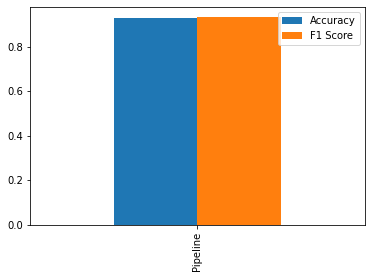

In [19]:
# # # fit the classifiers and print the accuracy and f1 score for each classifier and save them in a dataframe
grid_svc_df = pd.DataFrame(columns=['Accuracy', 'F1 Score'])
y_pred = grid_svc.best_estimator_.predict(X_test)
grid_svc_df.loc[grid_svc.best_estimator_.__class__.__name__] = [accuracy_score(y_test, y_pred), f1_score(y_test, y_pred, average='weighted')]


print(grid_svc.best_score_)
print(grid_svc.best_params_)

from IPython.display import Markdown as md


# display the results of the classifiers in a comparison bar plot
comparisonBarPlot = grid_svc_df.plot.bar()

# display the results of the classifiers in a markdown table
markDownTableResults = grid_svc_df.to_markdown()
md(markDownTableResults)# # # # # # # # # # # 

In [ ]:
import optuna
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.decomposition import PCA
from imblearn.under_sampling import RandomUnderSampler 
from sklearn.feature_selection import VarianceThreshold
from imblearn.pipeline import Pipeline
from sklearn.model_selection import cross_val_score
import numpy as np
from sklearn.neural_network import MLPClassifier
from sklearn.svm import SVC


# -- Define the objective function
def objective(trial):

    # -- Instantiate selector
    selector_threshold = trial.suggest_float('selector__threshold', 0.0, 0.1)

    selector = VarianceThreshold(threshold=selector_threshold)

    # -- Instantiate UnderSampler
    rus = RandomUnderSampler()

    # -- Instantiate scaler
    # (a) List scalers to chose from
    scalers = trial.suggest_categorical("scalers", ['minmax', 'standard'])

    # (b) Define your scalers
    if scalers == "minmax":
        scaler = MinMaxScaler()
    elif scalers == "standard":
        scaler = StandardScaler()

    # -- Instantiate dimensionality reduction
     # (a) List all dimensionality reduction options
    dim_red = trial.suggest_categorical("dim_red", ["PCA", None])

    # (b) Define the PCA algorithm and its hyperparameters
    if dim_red == "PCA":
        pca_n_components=trial.suggest_int("pca_n_components", 50, 171)
        dimen_red_algorithm=PCA(n_components=pca_n_components)
    # (c) No dimensionality reduction option
    else:
        dimen_red_algorithm='passthrough'


   # -- Instantiate estimator model
    C=trial.suggest_float('clf__C', 0.5, 1000.0)
    kernel=trial.suggest_categorical('clf__kernel', ['rbf', 'poly', 'sigmoid', 'linear'])
    gamma=trial.suggest_float('clf__gamma', 0.001,1)

    estimator = SVC(C=C, kernel=kernel, gamma=gamma)

    ##########


    # -- Make a pipeline
    pipeline = Pipeline([('selector', selector), ('scaler', scaler), ('rus', rus), ('pca', dimen_red_algorithm), ('clf', estimator)], memory = 'tmp')

    # -- Evaluate the score by cross-validation
    score = cross_val_score(pipeline, X_train, y_train, scoring='accuracy', cv=5)
    acc = score.mean() # calculate the mean of scores
    return acc

study = optuna.create_study(direction="maximize") # maximise the score during tuning
study.optimize(objective, n_trials=20) # run the objective function 20 times

print(study.best_trial) # print the best performing pipeline

|          |   Accuracy |   F1 Score |
|:---------|-----------:|-----------:|
| Pipeline |   0.921717 |   0.921722 |

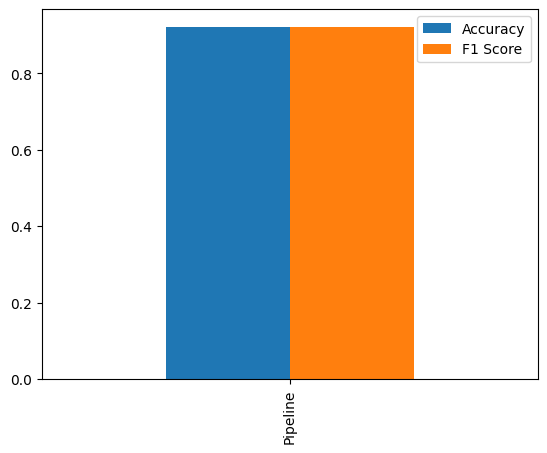

In [ ]:
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline
from sklearn.feature_selection import VarianceThreshold
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.neural_network import MLPClassifier
from sklearn.svm import SVC


# Initialize the transformers without hyperparameters
selector = VarianceThreshold(threshold=0.004018792290066309)
scaler = MinMaxScaler()
rus = RandomUnderSampler()

# Initialize the pipeline
pipe_svc_optuna = Pipeline([('selector', selector), ('scaler', scaler), ('rus', rus),  ('clf', SVC(C=272.19639794978974,kernel="linear", gamma=0.20803325037611617))], memory = 'tmp')


# Fit the grid search
pipe_svc_optuna.fit(X_train, y_train)


# # # fit the classifiers and print the accuracy and f1 score for each classifier and save them in a dataframe
pipe_svc_optuna_df = pd.DataFrame(columns=['Accuracy', 'F1 Score'])
y_pred = pipe_svc_optuna.predict(X_test)
pipe_svc_optuna_df.loc[pipe_svc_optuna.__class__.__name__] = [accuracy_score(y_test, y_pred), f1_score(y_test, y_pred, average='weighted')]



from IPython.display import Markdown as md


# display the results of the classifiers in a comparison bar plot
comparisonBarPlot = pipe_svc_optuna_df.plot.bar()

# display the results of the classifiers in a markdown table
markDownTableResults = pipe_svc_optuna_df.to_markdown()
md(markDownTableResults)# # # # # # # # # # # 





### **Conclusion for SVM:**

Results |   Accuracy | 	F1 Score |
----------- | ----------- | ----------- |
Out of the box |	0.838673 |	0.812597 |
Hyperparameter Optimization |	0.930756 |	0.930947  |
Optuna |	0.921717 |	0.921722 |

As we can see, we achieved considerable increases in performance by using hyperparameter optimization. The manual hyperparameter optimization was the most effective and produced the best model. That would be our selection for the best SVM estimator for our final model.

## Overall conclusion

We have tested different models and hyperparameter optimization techniques. When we compare the best MLP and SVM models, we can see that the SVM model performs slightly better and is faster to train. We will choose the SVM model as our final model.